2025-06-11 01:39:16.281941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749605956.556882      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749605956.630353      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Building model architecture skeleton...


2025-06-11 01:39:35.908021: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Loading weights from: /kaggle/input/fmri-final-model/tensorflow2/default/1/best_denoising_model.keras
Model weights loaded successfully!
Model compiled for testing.
Streaming for test: sub-05_task-training_run-01_bold.nii.gz
Streaming for test: sub-05_task-training_run-02_bold.nii.gz
Test data generator is ready.

Evaluating model on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 952s 7s/step - loss: 0.1637 - mae: 0.0121 - psnr: 33.3176 - ssim: 0.7985

Final Test Set Performance:
   - loss: 0.1653
   - mae: 0.0122
   - psnr: 33.2757
   - ssim: 0.7964

Visualizing a sample result from the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


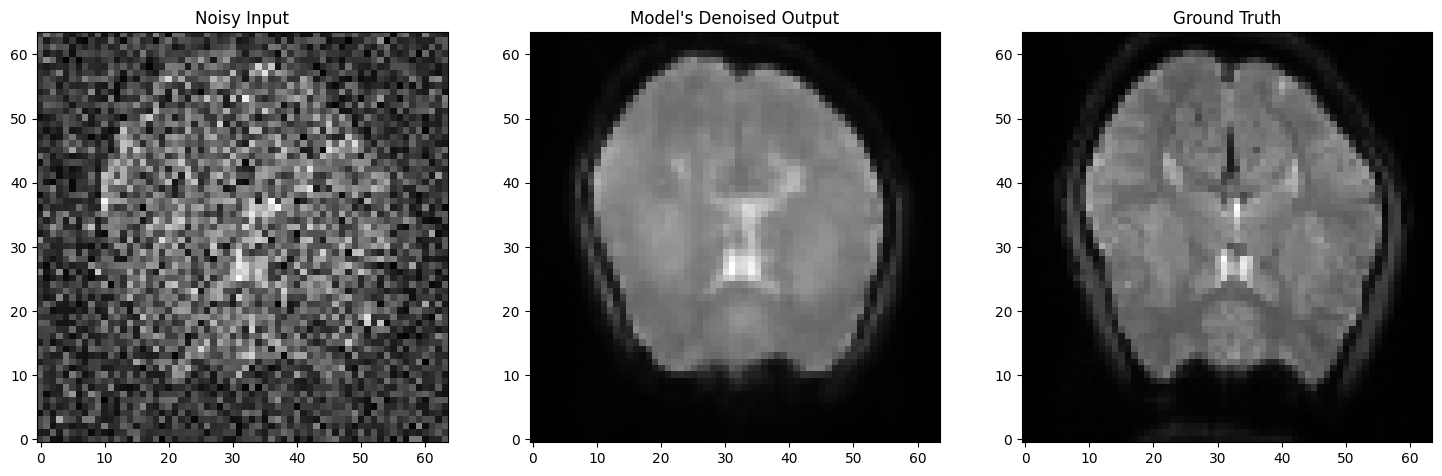

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import requests
import tempfile
import nibabel as nib
from scipy.ndimage import zoom
import math
from typing import List, Tuple


# Architecture functions required to rebuild the skeleton of the model---
def cbam_block(inputs, ratio=8):
    """Convolutional Block Attention Module."""
    channel = inputs.shape[-1]; shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True); shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True); avg_pool = layers.GlobalAveragePooling3D()(inputs); avg_pool = layers.Reshape((1, 1, 1, channel))(avg_pool); avg_pool = shared_layer_one(avg_pool); avg_pool = shared_layer_two(avg_pool); max_pool = layers.GlobalMaxPooling3D()(inputs); max_pool = layers.Reshape((1, 1, 1, channel))(max_pool); max_pool = shared_layer_one(max_pool); max_pool = shared_layer_two(max_pool); attention = layers.Add()([avg_pool, max_pool]); attention = layers.Activation('sigmoid')(attention); channel_att = layers.Multiply()([inputs, attention]); avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_att); max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_att); concat = layers.Concatenate(axis=-1)([avg_pool, max_pool]); attention = layers.Conv3D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat); return layers.Multiply()([channel_att, attention])

def build_attention_lstm_unet(input_shape, base_filters=16):
    """Builds the 3D U-Net model with Attention and LSTM bottleneck."""
    print("Building model architecture skeleton...")
    inputs = layers.Input(shape=input_shape); conv1 = layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(inputs)))); att1 = cbam_block(conv1); pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(att1); conv2 = layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(pool1)))); att2 = cbam_block(conv2); pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(att2); bottleneck = layers.Conv3D(base_filters * 4, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(pool2)); _, D, H, W, F = bottleneck.shape; bottleneck_reshaped = layers.Reshape((-1, F))(bottleneck); lstm_out = layers.Bidirectional(layers.LSTM(base_filters * 2, return_sequences=True))(bottleneck_reshaped); lstm_out_reshaped = layers.Reshape((D, H, W, base_filters * 4))(lstm_out); up3 = layers.Conv3DTranspose(base_filters * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(lstm_out_reshaped); merge3 = layers.Concatenate(axis=-1)([up3, att2]); conv3 = layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters * 2, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(merge3)))); up4 = layers.Conv3DTranspose(base_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv3); merge4 = layers.Concatenate(axis=-1)([up4, att1]); conv4 = layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(layers.Conv3D(base_filters, (3, 3, 3), padding='same', activation='relu')(layers.BatchNormalization()(merge4)))); outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(conv4); return models.Model(inputs=inputs, outputs=outputs)

# --- Test data preparation tools---
class OpenNeuroStreamer:
    def __init__(self, dataset_id: str = "ds002306"): self.dataset_id = dataset_id; self.base_url = f"https://s3.amazonaws.com/openneuro.org/{dataset_id}"
    def check_url_exists(self, url: str) -> bool:
        try: response = requests.head(url, timeout=15); return response.status_code == 200
        except: return False
    def stream_nii_file(self, url: str):
        print(f"Streaming for test: {os.path.basename(url)}"); temp_path = None
        try:
            with tempfile.NamedTemporaryFile(suffix='.nii.gz', delete=False) as temp_file:
                temp_path = temp_file.name; response = requests.get(url, stream=True, timeout=60); response.raise_for_status()
                for chunk in response.iter_content(chunk_size=8192): temp_file.write(chunk)
            img = nib.load(temp_path); return img.get_fdata(dtype=np.float32)
        except Exception as e: print(f"Error: {e}"); return None
        finally:
            if temp_path and os.path.exists(temp_path): os.unlink(temp_path)
    def load_test_data(self, subjects: List[str], max_files: int = 2):
        loaded_data = []; file_count = 0
        for subject in subjects:
            if file_count >= max_files: break
            for run_num in range(1, 6):
                if file_count >= max_files: break
                url = f"{self.base_url}/{subject}/func/{subject}_task-training_run-{run_num:02d}_bold.nii.gz"
                if self.check_url_exists(url):
                    data = self.stream_nii_file(url)
                    if data is not None: loaded_data.append(data); file_count += 1
        return loaded_data

class fMRIDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_arrays, batch_size=4, target_shape=(64, 64, 48), noise_level=0.1, shuffle=False): self.data_arrays = data_arrays; self.batch_size = batch_size; self.target_shape = target_shape; self.noise_level = noise_level; self.shuffle = shuffle; self.indices = [(i, t) for i, data in enumerate(self.data_arrays) for t in range(data.shape[3])]; self.on_epoch_end()
    def __len__(self): return math.floor(len(self.indices) / self.batch_size)
    def on_epoch_end(self): pass
    def _resample_volume(self, volume): zoom_factors = [self.target_shape[d] / volume.shape[d] for d in range(3)]; return zoom(volume, zoom_factors, order=1).astype(np.float32)
    def _normalize_volume(self, volume, v_min, v_max): return np.clip((volume - v_min) / (v_max - v_min + 1e-7), 0, 1)
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]; current_batch_size = len(batch_indices)
        batch_shape = (current_batch_size, self.target_shape[2], self.target_shape[0], self.target_shape[1], 1)
        X, y = np.empty(batch_shape, dtype=np.float32), np.empty(batch_shape, dtype=np.float32)
        for i, (file_idx, time_idx) in enumerate(batch_indices):
            clean_volume_raw = self.data_arrays[file_idx][:, :, :, time_idx]; clean_volume_resampled = self._resample_volume(clean_volume_raw)
            y_volume_norm = self._normalize_volume(clean_volume_resampled, 0, 3000)
            n1 = np.random.normal(0, self.noise_level, size=y_volume_norm.shape).astype('float32'); n2 = np.random.normal(0, self.noise_level, size=y_volume_norm.shape).astype('float32')
            X_volume_norm = np.sqrt((y_volume_norm + n1)**2 + n2**2)
            y[i,] = np.transpose(y_volume_norm, (2, 0, 1))[..., np.newaxis]; X[i,] = np.transpose(X_volume_norm, (2, 0, 1))[..., np.newaxis]
        return X, y

# --- Custom metrics and loss function (Required to compile the model) ---
def psnr(y_true, y_pred): return tf.image.psnr(y_true, y_pred, max_val=1.0)
def ssim(y_true, y_pred): return tf.image.ssim(y_true, y_pred, max_val=1.0)
def composite_loss(y_true, y_pred):
    mae_calculator = tf.keras.losses.MeanAbsoluteError()
    mae_loss = mae_calculator(y_true, y_pred)
    ssim_loss = 1.0 - tf.image.ssim(y_pred, y_true, max_val=1.0)
    return 0.2 * mae_loss + 0.8 * ssim_loss

# ===================================================================
# MAIN CODE
# ===================================================================

# Getting model 2 training and checking test results
MODEL_PATH = "/kaggle/input/fmri-final-model/tensorflow2/default/1/model_2.keras" 

# STEP 1: Create the empty skeleton of the model.
input_shape = (48, 64, 64, 1)
model = build_attention_lstm_unet(input_shape)

print(f"\nLoading weights from: {MODEL_PATH}")
try:
    # STEP 2: Load only trained weights on this empty frame.
    model.load_weights(MODEL_PATH)
    print("Model weights loaded successfully!")
    
    # STEP 3: Build the model for testing.
    model.compile(loss=composite_loss, metrics=['mae', psnr, ssim])
    print("Model compiled for testing.")

    # STEP 4: Prepare test data.
    streamer = OpenNeuroStreamer()
    test_data_runs = streamer.load_test_data(subjects=["sub-05"], max_files=2)
    
    if not test_data_runs:
        raise ValueError("Could not download test data. Check internet or subject ID.")

    test_ds = fMRIDataGenerator(data_arrays=test_data_runs, batch_size=4, shuffle=False)
    print("Test data generator is ready.")

    # STEP 5: Get numerical results.
    print("\nEvaluating model on the test set...")
    final_metrics = model.evaluate(test_ds, return_dict=True)
    print("\nFinal Test Set Performance:")
    for key, value in final_metrics.items():
        print(f"   - {key}: {value:.4f}")

    # STEP 6: Get visual results.
    print("\nVisualizing a sample result from the test set...")
    x_test_batch, y_test_batch = test_ds.__getitem__(0)
    y_pred_batch = model.predict(x_test_batch)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    slice_idx = x_test_batch.shape[1] // 2
    axes[0].imshow(np.rot90(x_test_batch[0, slice_idx, :, :, 0]), cmap='gray', origin='lower'); axes[0].set_title('Noisy Input')
    axes[1].imshow(np.rot90(y_pred_batch[0, slice_idx, :, :, 0]), cmap='gray', origin='lower'); axes[1].set_title("Model's Denoised Output")
    axes[2].imshow(np.rot90(y_test_batch[0, slice_idx, :, :, 0]), cmap='gray', origin='lower'); axes[2].set_title('Ground Truth')
    plt.show()

except FileNotFoundError:
    print(f"\nERROR: The file was not found at the specified path: {MODEL_PATH}")
    print("Please perform the following checks:")
    print("1. In the right-side panel, under 'Input', find the name of the dataset containing your model.")
    print("2. Expand it and find your '.keras' file.")
    print("3. Click the 'Copy file path' icon next to the file.")
    print("4. Paste that correct path into the MODEL_PATH variable in this script and rerun.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

In [3]:
# CELL 1: PREPARE DATA GENERATORS

# Check if necessary classes and data exist
if 'OpenNeuroStreamer' in globals() and 'fMRIDataGenerator' in globals() and 'model' in globals():
    print(" Preparing BOTH validation and test data generators...")
    
    streamer = OpenNeuroStreamer()
    
    # Download sub-03/04 for Validation, sub-05 for Testing
    print("\nDownloading validation data...")
    val_data_runs = streamer.load_test_data(subjects=["sub-03", "sub-04"], max_files=2)
    
    print("\nDownloading test data...")
    test_data_runs = streamer.load_test_data(subjects=["sub-05"], max_files=2)

    if val_data_runs and test_data_runs:
        # Create generators
        val_ds = fMRIDataGenerator(data_arrays=val_data_runs, batch_size=4, shuffle=False)
        test_ds = fMRIDataGenerator(data_arrays=test_data_runs, batch_size=4, shuffle=False)
        
        print("\n 'val_ds' and 'test_ds' are now ready!")
    else:
        print(" Could not download all necessary data.")

else:
    print(" Critical components ('OpenNeuroStreamer', 'fMRIDataGenerator', 'model') are missing.")

🛠️ Preparing BOTH validation and test data generators...

Streaming for test: sub-03_task-training_run-01_bold.nii.gz
Streaming for test: sub-03_task-training_run-02_bold.nii.gz

Streaming for test: sub-05_task-training_run-01_bold.nii.gz
Streaming for test: sub-05_task-training_run-02_bold.nii.gz

✅ 'val_ds' and 'test_ds' are now ready!



Visualizing Model Performance on the VALIDATION Set
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


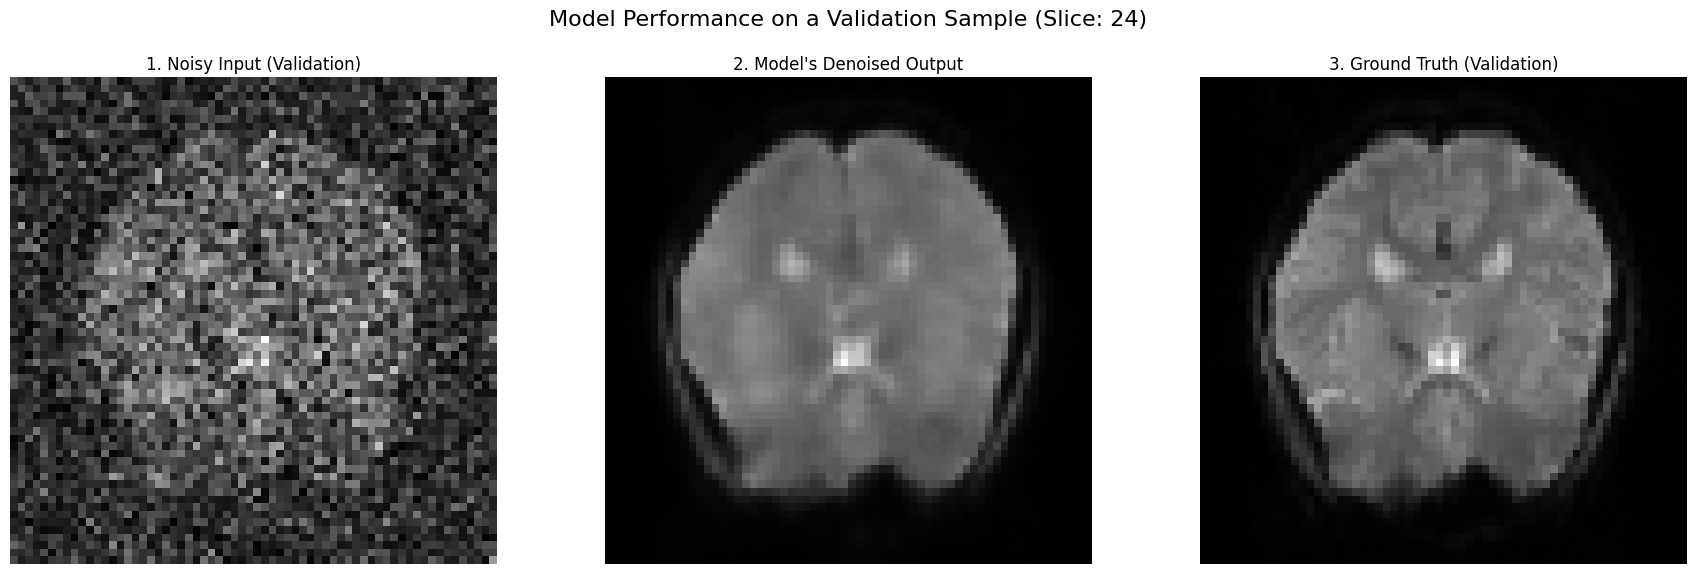

In [4]:
# CELL 2: VISUALIZE VALIDATION SET

import numpy as np
import matplotlib.pyplot as plt

# Check for the existence of required variables
if 'model' in globals() and 'val_ds' in globals():
    
    print("\n" + "="*60)
    print("Visualizing Model Performance on the VALIDATION Set")
    print("=" * 60)

    # Take a batch from the validation generator
    x_val_batch, y_val_batch = val_ds.__getitem__(0)
    
    # Make a prediction
    y_pred_val_batch = model.predict(x_val_batch)

    # Visualize an example
    sample_idx = 0 
    slice_idx = x_val_batch.shape[1] // 2 

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Model Performance on a Validation Sample (Slice: {slice_idx})", fontsize=16)

    axes[0].imshow(np.rot90(x_val_batch[sample_idx, slice_idx, :, :, 0]), cmap='gray', origin='lower')
    axes[0].set_title('1. Noisy Input (Validation)')
    axes[0].axis('off')

    axes[1].imshow(np.rot90(y_pred_val_batch[sample_idx, slice_idx, :, :, 0]), cmap='gray', origin='lower')
    axes[1].set_title("2. Model's Denoised Output")
    axes[1].axis('off')
    
    axes[2].imshow(np.rot90(y_val_batch[sample_idx, slice_idx, :, :, 0]), cmap='gray', origin='lower')
    axes[2].set_title('3. Ground Truth (Validation)')
    axes[2].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print(" 'model' or 'val_ds' not found. Please run the data preparation cell (Cell 1) first.")